In [364]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

from pprint import pprint

In [365]:
actors_df = pd.read_csv("Craig_portion/Resources/tmdb_5000_credits.csv")
actors_df.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [366]:
movies = pd.read_csv("Craig_portion/Resources/tmdb_5000_movies.csv")
movies_df = pd.DataFrame(movies)
movies_df=movies_df.rename(columns={"overview": "Overview", "vote_average":"Average Vote", "title":"Title", "revenue":"Revenue", "budget":"Budget"})
#converting money to today's money

movies_df.head()

,Budget,genres,homepage,id,keywords,original_language,original_title,Overview,popularity,production_companies,production_countries,release_date,Revenue,runtime,spoken_languages,status,tagline,Title,Average Vote,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


# Number of movies relased in time
Because of significant increase inn numbers of movies released in time, we break down the dataset into time buckets. 

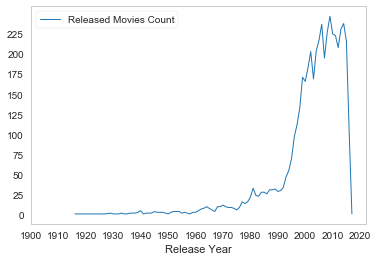

In [367]:
# Add column Release Year
movies_df['Release Year']=movies_df['release_date'].str[:4].astype(float)
movies_count_by_year=movies_df.groupby(by="Release Year")["Title"].count().reset_index().rename(columns={"Title":"Released Movies Count"})
movies_count_by_year.plot(x="Release Year",y="Released Movies Count")
plt.grid(axis="both")
plt.xticks(np.arange(1900,2021,10))
plt.yticks(np.arange(0,250,25))
plt.show()

In [368]:
year_buckets=[1940,1960,1995]
movie_year_bucket=[]
movie_year_bucket_no=[]

for index,row in movies_df.iterrows():
    if row["Release Year"]<year_buckets[0]:
        movie_year_bucket.append("Before "+str(year_buckets[0]))
        movie_year_bucket_no.append(1)
    elif row["Release Year"]>=year_buckets[-1]:
        movie_year_bucket.append("On or after "+str(year_buckets[-1]))
        movie_year_bucket_no.append(len(year_buckets)+1)
    else:
        ok=False
        for i in range(len(year_buckets)-1):
            if(year_buckets[i]<=row["Release Year"]<year_buckets[i+1]):
                movie_year_bucket.append(str(year_buckets[i])+" to "+str(year_buckets[i+1]))
                movie_year_bucket_no.append(i+2)                
                ok=True
        if(ok==False):
            movie_year_bucket.append("undefined")
            movie_year_bucket_no.append(0)
            

movies_df["Years"]=movie_year_bucket
movies_df["Release Years Bucket"]=movie_year_bucket_no


In [369]:
movies_money_df=movies_df.loc[(movies_df["Average Vote"]>0) & (movies_df["Budget"]>0)& (movies_df["Revenue"]>0),["Title","Release Year", "Years", "Release Years Bucket", "Budget","Revenue","Average Vote"]]
# cteate a column with present day money value for Revenue
for index,row in movies_money_df.iterrows():
   movies_money_df.at[index,"Revenue Adjusted"]=row["Revenue"]*(math.exp(0.03*(2017-row["Release Year"])))
   movies_money_df.at[index,"Budget Adjusted"]=row["Budget"]*(math.exp(0.03*(2017-row["Release Year"])))

# Revenues
Because of large difference in revenues, we break down movies into revenue buckets.
Revenues were adjusted to current money value at inflation rate of 3% per year. 

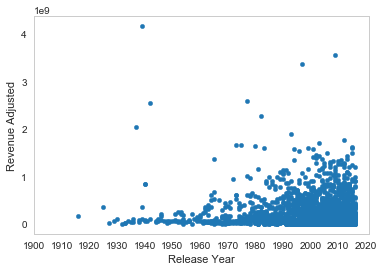

In [371]:
movies_money_df.plot(x="Release Year",y="Revenue Adjusted",kind="scatter",subplots=True)
plt.grid(axis="both")
plt.xticks(np.arange(1900,2021,10))
#plt.yticks(np.arange(0,5000000001,1000000000))

plt.show()

Movies with higest revenues are listed below. The explanationn for revenues of "Gone with the Wind" and "Bambi" movies is an open question due to limited information on the dataset used. One possible explanationn is the cumulative revenue over time since 30s-40s due to popularity of these movies.

In [372]:
# adj_revenue_mean=np.mean(movies_money_df["Revenue Adjusted"])
# adj_revenue_std=np.std(movies_money_df["Revenue Adjusted"])
movies_money_df.sort_values(["Revenue Adjusted"],ascending=[False],inplace=True)
movies_money_df[movies_money_df["Revenue Adjusted"]>2000000000]

,Title,Release Year,Years,Release Years Bucket,Budget,Revenue,Average Vote,Revenue Adjusted,Budget Adjusted
3813,Gone with the Wind,1939.0,Before 1940,1,4000000,400176459,7.7,4.154326e+09,4.152495e+07
0,Avatar,2009.0,On or after 1995,4,237000000,2787965087,7.2,3.544198e+09,3.012860e+08
25,Titanic,1997.0,On or after 1995,4,200000000,1845034188,7.5,3.361871e+09,3.644238e+08
2912,Star Wars,1977.0,1960 to 1995,3,11000000,775398007,8.1,2.574412e+09,3.652129e+07
4441,Bambi,1942.0,1940 to 1960,2,858000,267447150,6.8,2.537468e+09,8.140477e+06
2967,E.T. the Extra-Terrestrial,1982.0,1960 to 1995,3,10500000,792910554,7.3,2.265862e+09,3.000534e+07
4259,Snow White and the Seven Dwarfs,1937.0,Before 1940,1,1488423,184925486,6.9,2.038466e+09,1.640715e+07


In [373]:
revenue_buckets=[100000,10000000,1000000000]
revenue_bucket=[]
revenue_bucket_no=[]

for index,row in movies_money_df.iterrows():
    if row["Revenue Adjusted"]<revenue_buckets[0]:
        revenue_bucket.append("Under "+str(revenue_buckets[0]))
        revenue_bucket_no.append(1)
    elif row["Revenue Adjusted"]>=revenue_buckets[-1]:
        revenue_bucket.append("Above "+str(revenue_buckets[-1]))
        revenue_bucket_no.append(len(revenue_buckets)+1)
    else:
        ok=False
        for i in range(len(year_buckets)-1):
            if(revenue_buckets[i]<=row["Revenue Adjusted"]<revenue_buckets[i+1]):
                revenue_bucket.append(str(revenue_buckets[i])+" to "+str(revenue_buckets[i+1]))
                revenue_bucket_no.append(i+2)
                ok=True
        if(ok==False):
            revenue_bucket.append("undefined")
            revenue_bucket_no.append(0)
            

movies_money_df["Revenue Tier"]=revenue_bucket
movies_money_df["Revenue Tier No"]=revenue_bucket_no


# Revenues by release year and revenue tiers

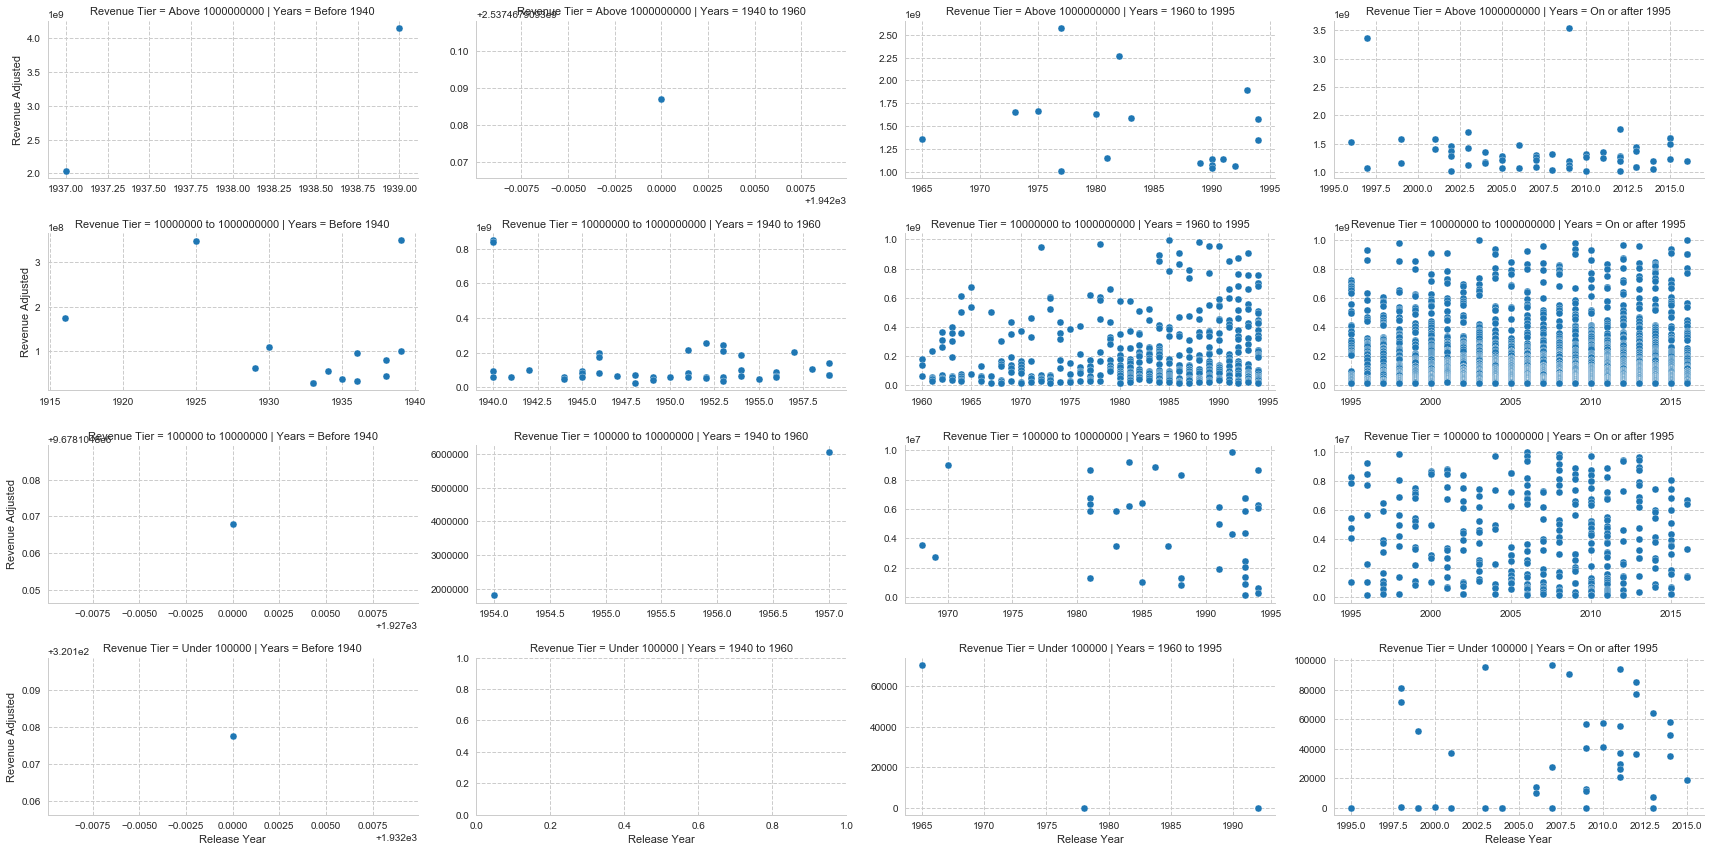

In [374]:
#movies_money_df.groupby(['Release Years', 'Release Year', 'Revenue Adjusted']).agg('count').unstack(0).plot(kind='scatter', subplots=True)
movies_money_df.sort_values(["Revenue Tier No", "Release Years Bucket"],ascending=[False, True],inplace=True)
g = sns.FacetGrid(movies_money_df, row="Revenue Tier", col="Years", sharex=False, sharey=False, size=3,aspect=2)
g = g.map(plt.scatter, 'Release Year', 'Revenue Adjusted', edgecolor="w")

In [9]:
movies_df["status"].value_counts()

Released           4795
Rumored               5
Post Production       3
Name: status, dtype: int64

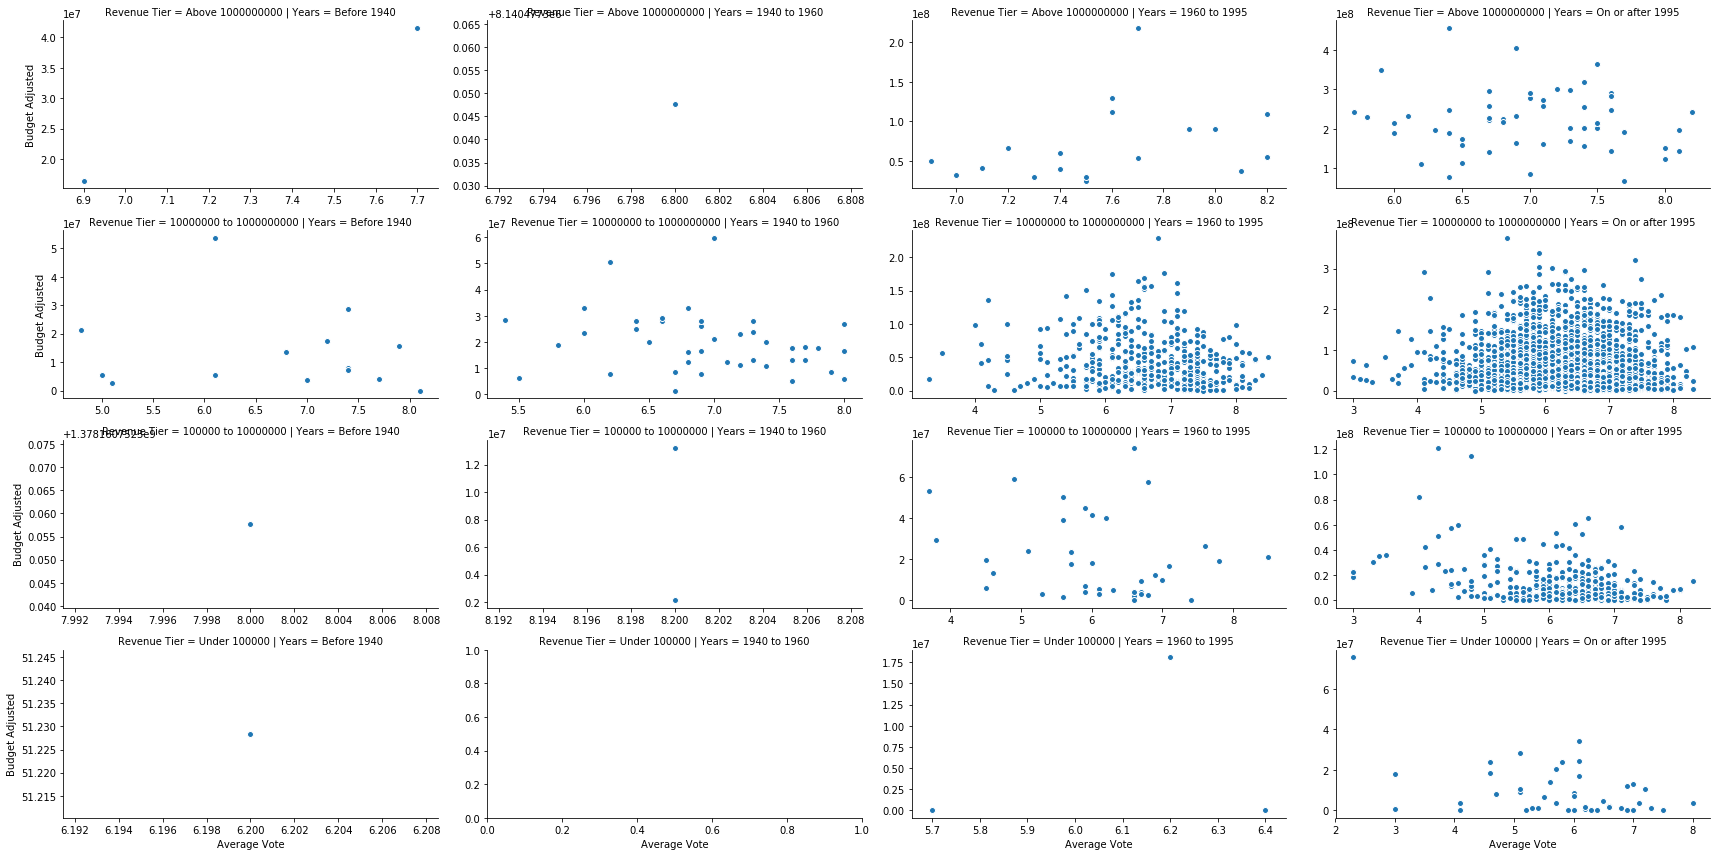

In [321]:
#movies_money_df.groupby(['Release Years', 'Release Year', 'Revenue Adjusted']).agg('count').unstack(0).plot(kind='scatter', subplots=True)
movies_money_df.sort_values(["Revenue Tier No", "Release Years Bucket"],ascending=[False, True],inplace=True)
g = sns.FacetGrid(movies_money_df, row="Revenue Tier", col="Years", sharex=False, sharey=False, size=3,aspect=2)
g = g.map(plt.scatter, 'Average Vote', 'Budget Adjusted', edgecolor="w")

In [329]:
# create datafarme with movie actors - first 3 for each movie

for index,row in actors_df.iterrows():
    given_movies_actor_value=eval(row['cast'])
    given_movie_actors_df = pd.DataFrame(given_movies_actor_value)
    given_movie_actors_df["Title"]=row['title']
    try:
        given_movie_actors_df.drop(axis=1,columns=['cast_id','character','credit_id','gender','id','order'],inplace=True)
    except:
        pass
    
    if(index==0):
        movie_actor_df=given_movie_actors_df.iloc[0:3]
    else:
        movie_actor_df=movie_actor_df.append(given_movie_actors_df.iloc[0:3])

movie_actor_df.rename(columns={"name":"Actor"},inplace=True)   
movie_actor_df.head()   

,Title,Actor
0,Avatar,Sam Worthington
1,Avatar,Zoe Saldana
2,Avatar,Sigourney Weaver
0,Pirates of the Caribbean: At World's End,Johnny Depp
1,Pirates of the Caribbean: At World's End,Orlando Bloom


In [330]:
movies_money_df.head()

,Title,Release Year,Years,Release Years Bucket,Budget,Revenue,Average Vote,Revenue Adjusted,Budget Adjusted,Revenue Tier,Revenue Tier No
3813,Gone with the Wind,1939.0,Before 1940,1,4000000,400176459,7.7,4.154326e+09,4.152495e+07,Above 1000000000,4
4259,Snow White and the Seven Dwarfs,1937.0,Before 1940,1,1488423,184925486,6.9,2.038466e+09,1.640715e+07,Above 1000000000,4
4441,Bambi,1942.0,1940 to 1960,2,858000,267447150,6.8,2.537468e+09,8.140477e+06,Above 1000000000,4
2912,Star Wars,1977.0,1960 to 1995,3,11000000,775398007,8.1,2.574412e+09,3.652129e+07,Above 1000000000,4
2967,E.T. the Extra-Terrestrial,1982.0,1960 to 1995,3,10500000,792910554,7.3,2.265862e+09,3.000534e+07,Above 1000000000,4


In [331]:
# add max avg revenue of prior movies by actor (first 3 in the cast), as a measure of prior popularity of the actors starring
movie_max_avg_rev_by_actor=[]
for index,row in movies_money_df.iterrows():
    curr_movie_actors_df=movie_actor_df.loc[movie_actor_df['Title']==row['Title']]
    curr_movie_actors_all_movies_df=pd.DataFrame.merge(curr_movie_actors_df,movie_actor_df,on='Actor')
    prior_movies_df=movies_money_df.loc[movies_money_df['Release Year']<row['Release Year']]
    curr_movie_actors_all_prior_movies_df=pd.DataFrame.merge(curr_movie_actors_all_movies_df,prior_movies_df,left_on="Title_y", right_on="Title")

    curr_movie_actors_all_prior_movies_before_gr_ser=curr_movie_actors_all_prior_movies_df.groupby(by="Actor").mean()
    try:
        max_actor_avg_prior_rev=max(curr_movie_actors_all_prior_movies_before_gr_ser["Revenue Adjusted"])
        movie_max_avg_rev_by_actor.append(max_actor_avg_prior_rev)
    except:
        movie_max_avg_rev_by_actor.append(0)

se = pd.Series(movie_max_avg_rev_by_actor)
movies_money_df['Max Prior Avg Revenue of Starring Actors'] = se.values

movies_money_df
    

,Title,Release Year,Years,Release Years Bucket,Budget,Revenue,Average Vote,Revenue Adjusted,Budget Adjusted,Revenue Tier,Revenue Tier No,Max Prior Avg Revenue of Starring Actors
3813,Gone with the Wind,1939.0,Before 1940,1,4000000,400176459,7.7,4.154326e+09,4.152495e+07,Above 1000000000,4,5.427574e+07
4259,Snow White and the Seven Dwarfs,1937.0,Before 1940,1,1488423,184925486,6.9,2.038466e+09,1.640715e+07,Above 1000000000,4,0.000000e+00
4441,Bambi,1942.0,1940 to 1960,2,858000,267447150,6.8,2.537468e+09,8.140477e+06,Above 1000000000,4,0.000000e+00
2912,Star Wars,1977.0,1960 to 1995,3,11000000,775398007,8.1,2.574412e+09,3.652129e+07,Above 1000000000,4,0.000000e+00
2967,E.T. the Extra-Terrestrial,1982.0,1960 to 1995,3,10500000,792910554,7.3,2.265862e+09,3.000534e+07,Above 1000000000,4,0.000000e+00
675,Jurassic Park,1993.0,1960 to 1995,3,63000000,920100000,7.6,1.890284e+09,1.294293e+08,Above 1000000000,4,3.039596e+07
2809,Jaws,1975.0,1960 to 1995,3,7000000,470654000,7.5,1.659254e+09,2.467795e+07,Above 1000000000,4,5.975112e+08
2808,The Exorcist,1973.0,1960 to 1995,3,8000000,441306145,7.5,1.651995e+09,2.994737e+07,Above 1000000000,4,7.363483e+07
1990,The Empire Strikes Back,1980.0,1960 to 1995,3,18000000,538400000,8.2,1.633699e+09,5.461845e+07,Above 1000000000,4,2.574412e+09
1490,Return of the Jedi,1983.0,1960 to 1995,3,32350000,572700000,7.9,1.588209e+09,8.971285e+07,Above 1000000000,4,2.104055e+09


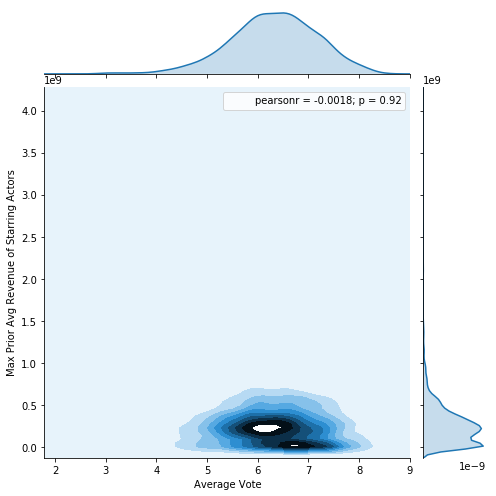

In [333]:
sns.jointplot(y="Max Prior Avg Revenue of Starring Actors", x="Average Vote", data=movies_money_df, size=7, kind="kde")

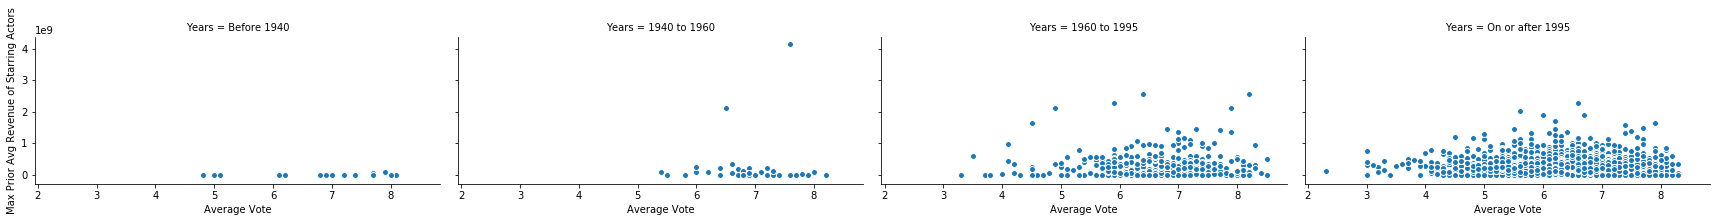

In [340]:
movies_money_df.sort_values("Release Years Bucket",ascending=[True],inplace=True)
g = sns.FacetGrid(movies_money_df, col="Years", sharex=True, size=3,aspect=2)
g = g.map(plt.scatter, "Average Vote", "Max Prior Avg Revenue of Starring Actors", edgecolor="w")
plt.show()

In [341]:
movie_actor_df.dropna(inplace=True)
movie_actor_df.describe()

,Title,Actor
count,14250,14250
unique,4757,5687
top,Batman,Robert De Niro
freq,6,46


In [347]:
# create datafarme with movies-genres

for index,row in movies_df.iterrows():
    given_movies_genre_value=eval(row['genres'])
    given_movie_genres_df = pd.DataFrame(given_movies_genre_value)
    given_movie_genres_df["Title"]=row['Title']
    try:
        given_movie_genres_df.drop(axis=1,columns=['id'],inplace=True)
    except:
        pass
    
    if(index==0):
        movie_genre_df=given_movie_genres_df
    else:
        movie_genre_df=movie_genre_df.append(given_movie_genres_df)

movie_genre_df.rename(columns={"name":"Genre"},inplace=True)   
movie_genre_df.head()  

,Title,Genre
0,Avatar,Action
1,Avatar,Adventure
2,Avatar,Fantasy
3,Avatar,Science Fiction
0,Pirates of the Caribbean: At World's End,Adventure


In [348]:
movie_genre_df.dropna(inplace=True)                                                   
movie_genre_df.describe()

,Title,Genre
count,12160,12160
unique,4772,20
top,The Host,Drama
freq,8,2297


In [349]:
genres_list={"Mood":['Comedy','Thriller','Horror','Drama','Action','Fantasy','Mystery'],
"Concept":['Crime','Science Fiction','Family','Romance','Adventure','Western','War','History']}
movie_genre_df["Genre"].value_counts()

Drama              2297
Comedy             1722
Thriller           1274
Action             1154
Romance             894
Adventure           790
Crime               696
Science Fiction     535
Horror              519
Family              513
Fantasy             424
Mystery             348
Animation           234
History             197
Music               185
War                 144
Documentary         110
Western              82
Foreign              34
TV Movie              8
Name: Genre, dtype: int64

In [350]:
actor_genres_df=pd.DataFrame.merge(movie_actor_df,movie_genre_df, on="Title")
actor_genres_df.dropna(inplace=True)
actor_genres_df.head()

,Title,Actor,Genre
0,Avatar,Sam Worthington,Action
1,Avatar,Sam Worthington,Adventure
2,Avatar,Sam Worthington,Fantasy
3,Avatar,Sam Worthington,Science Fiction
4,Avatar,Zoe Saldana,Action


In [354]:
actor_genres_counts=actor_genres_df.groupby(by=["Actor","Genre"]).count()
actor_genres_counts.rename(columns={"Title":"Movies Count"},inplace=True)
actor_genres_counts.reset_index(inplace=True)
actor_genres_counts

,Actor,Genre,Movies Count
0,"""Weird Al"" Yankovic",Comedy,1
1,50 Cent,Action,1
2,50 Cent,Crime,1
3,50 Cent,Drama,2
4,50 Cent,Thriller,1
5,A.J. Buckley,Comedy,1
6,A.J. Buckley,Family,1
7,A.J. Cook,Horror,1
8,A.J. Cook,Mystery,1
9,A.J. DeLucia,Science Fiction,1


In [356]:
actors_name=[]
actors_genre=[]
actors_genre_count=[]

for genre in genres_list["Mood"]:
    given_genre_actors=actor_genres_counts.loc[actor_genres_counts["Genre"]==genre]
    given_genre_actors_max=given_genre_actors.loc[given_genre_actors["Movies Count"].idxmax()]
    actors_genre.append(genre)
    actors_name.append(given_genre_actors_max["Actor"])
    actors_genre_count.append(given_genre_actors_max["Movies Count"])


actors_genre_top_df=pd.DataFrame.from_dict({'Actor': actors_name, 'Genre': actors_genre, 'Count': actors_genre_count})
actors_genre_top_df


,Actor,Count,Genre
0,Will Ferrell,26,Comedy
1,Bruce Willis,21,Thriller
2,Robert Englund,9,Horror
3,Matt Damon,25,Drama
4,Arnold Schwarzenegger,20,Action
5,Johnny Depp,11,Fantasy
6,Liam Neeson,7,Mystery


In [360]:
movies_genre_timeline_df=pd.DataFrame.merge(movies_df,movie_genre_df, on="Title").groupby(by=["Genre","Release Year"]).count()
movies_genre_timeline_df.reset_index(inplace=True)
movies_genre_timeline_df=movies_genre_timeline_df[["Genre","Release Year","Title"]]
movies_genre_timeline_df.rename(columns={"Title": "Movies Count"},inplace=True)
movies_genre_timeline_df.head()

,Genre,Release Year,Movies Count
0,Action,1930.0,1
1,Action,1936.0,1
2,Action,1947.0,1
3,Action,1949.0,1
4,Action,1950.0,1


AttributeError: 'AxesSubplot' object has no attribute 'show'

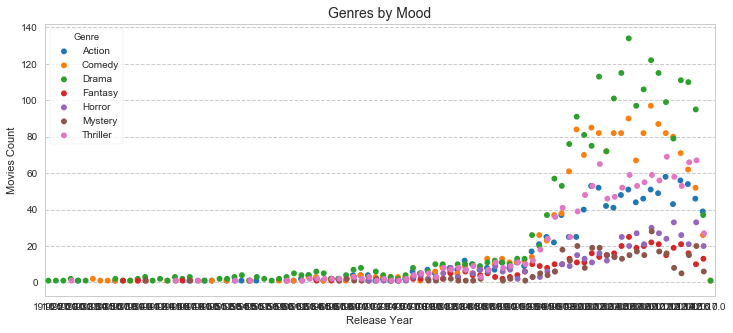

In [362]:
for key, value in genres_list["Mood"].items():
    sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
    sns.set_style("whitegrid", {'axes.linewidth': 1.0, 'legend.frameon': True, 'grid.linestyle': u'--'})
    plt=sns.pointplot(x="Release Year",y="Movies Count",data=movies_genre_timeline_df[movies_genre_timeline_df['Genre'].isin(value)],hue="Genre", scale=1, join=False,dodge=True)
    plt.figure.set_size_inches(12,5)
    plt.axes.set_title('Genres by '+key, fontsize=14)
    plt.show()
    

In [ ]:
plt1=sns.pointplot(x="Release Year",y="Movies Count",data=movies_genre_timeline_df,hue="Genre", markers="")
plt1.figure.set_size_inches(12,5)
plt1.axes.set_title('Genres over time', fontsize=14)
plt.show()

In [ ]:
movies_money_df.plot(x="Release Year",y="Revenue Adjusted",kind="bar",stacked=True)
plt.show()